# Real or Not? NLP with Disaster Tweets Kaggle Challenge
William Yu

## Introduction
The purpose of this challenge is, given a set of Tweets, are you able to identify whether a Tweet is tweeting about a real disaster? The premise is simple, but what lies in the core of this challenge are basic Natural Language Processing (NLP) and binary classification techniques. 

Let's get started.

## Loading the Data

In [1]:
# import necessary packages
import pandas as pd 
import numpy as np
import re

In [2]:
# import train and test data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


We see that we have 5 columns, `id`, `keyword`,`location`, `text`, and the `target` label. The labels are encoded with 0 and 1's to indicate if a disaster took place, with 1 being the tweet is about a real disaster. 

We'll be mainly focusing on the `text` column and deriving meaning on the actual tweet itself to aid us in our analysis.

## Preprocessing and Vizualization

Some things we want to do prior to modeling:
- Remove html tags, urls and other special characters 
- Lemmatize words and create a vocabulary
- Visualize word frequencies of all tweets

In order to do visualze the word frequencies we'll be using a **Bag of Words (BOW)** model, which will preserve every word in the given text and its multiplicity but discard the order of the words. This way, we can see how many times a given word has appeared in our corpus, or our collection of tweets. 

In [3]:
# function to remove html tags in text
def htmlremove(text):
    return re.sub('<[^<]+?>', '', text)

train['text'] = train['text'].apply(htmlremove)
test['text'] = test['text'].apply(htmlremove)     

We want to remove any sort of url's or username mentions as they have little to no influence on the prediction:

In [4]:
# remove url and @'s
def urlremove(text):
    return re.sub(r"(?:\@|https?\://)\S+", "", text)

train['text'] = train['text'].apply(urlremove)
test['text'] = test['text'].apply(urlremove)

Remove emoji's, contractions, special characters and numbers if there are any:

In [5]:
# remove emojis
# https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python
def remove_emoji(text):
    emoji_pattern = re.compile(
        u"(\ud83d[\ude00-\ude4f])|"  # emoticons
        u"(\ud83c[\udf00-\uffff])|"  # symbols & pictographs (1 of 2)
        u"(\ud83d[\u0000-\uddff])|"  # symbols & pictographs (2 of 2)
        u"(\ud83d[\ude80-\udeff])|"  # transport & map symbols
        u"(\ud83c[\udde0-\uddff])"  # flags (iOS)
        "+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

train['text'] = train['text'].apply(remove_emoji)
test['text'] = test['text'].apply(remove_emoji)

In [6]:
# remove contractions
# taken from: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
def decontracted(text):
    if '’' in text:
        text = text.replace("’", "'")
    # specific
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)

    # general
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text

train['text'] = train['text'].apply(decontracted)
test['text'] = test['text'].apply(decontracted)

In [7]:
# remove special characters
def characterremove(text):
    return re.sub('\W+|_', ' ', text)

train.text = train.text.apply(characterremove)
test.text = test.text.apply(characterremove)

In [8]:
# remove numbers in text
def remove_numbers(text):
    # define the pattern to keep
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' 
    return re.sub(pattern, '', text)

train.text = train.text.apply(remove_numbers)
# lower-case text and remove unnecessary whitespaces
train.text = train.text.str.lower()
train.text = train.text.str.strip()

test.text = test.text.apply(remove_numbers)
test.text = test.text.str.lower()
test.text = test.text.str.strip()

We finished the processing of our data and now can move to a short vizualization using a BOW approach.

To get our BOW, we import `CountVectorizer` from sklearn's `feature_extraction.text` package and fit it on our data to get the word occurences.

What `CountVectorizer` is doing is tokenizing each word in a document, and then building a vocabulary consisting of all these words. We also specified a list of stopwords, which will remove certain words that are present in the document from our vocabulary. `min_df` corresponds to the minimum number of documents a word has to appear in to be put into the vocabulary, which will remove infrequent words.

Using this vocabulary, we can create a group representation as a sparse matrix, where the representation '1' equates to the word being in a given document, and '0' as not. A row corresponds to a document (subject line or body in this case). So most of these entries in the matrix will be 0, hence the sparse matrix notation.

This corresponds to the line in the code above: `X = init_vec.fit_transform(new_corpus)` where X is the sparse matrix.

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords

stopwords = nltk.corpus.stopwords.words('english')

def get_top_20(ngram_range, new_corpus, stopwords, min_df):
    init_vec = CountVectorizer(ngram_range=ngram_range, stop_words = stopwords, min_df=min_df)
    # get sparse matrix from vocabulary
    X = init_vec.fit_transform(new_corpus)
    count_list = X.toarray().sum(axis=0) 
    word_list = init_vec.get_feature_names()
    counts = dict(zip(word_list,count_list))
    top_20 = sorted(counts.items(), key=lambda x:x[1], reverse=True)[:20]
    return top_20, counts

top_20, counts = get_top_20((1,1), train.text, stopwords, 4)
top_20

[('like', 348),
 ('amp', 344),
 ('fire', 254),
 ('get', 229),
 ('new', 226),
 ('via', 220),
 ('news', 201),
 ('people', 199),
 ('one', 198),
 ('would', 191),
 ('video', 165),
 ('disaster', 158),
 ('emergency', 158),
 ('police', 143),
 ('body', 131),
 ('time', 130),
 ('still', 129),
 ('us', 126),
 ('burning', 121),
 ('california', 121)]

We see that the word "like" has the most occurences with 348, followed closely by "amp". "amp" is actually a character reference in HTML that stands for "&", which is commonly called an "ampersand". This won't have any meaning towards our prediction, so we can add it to our stopwords when modeling later.

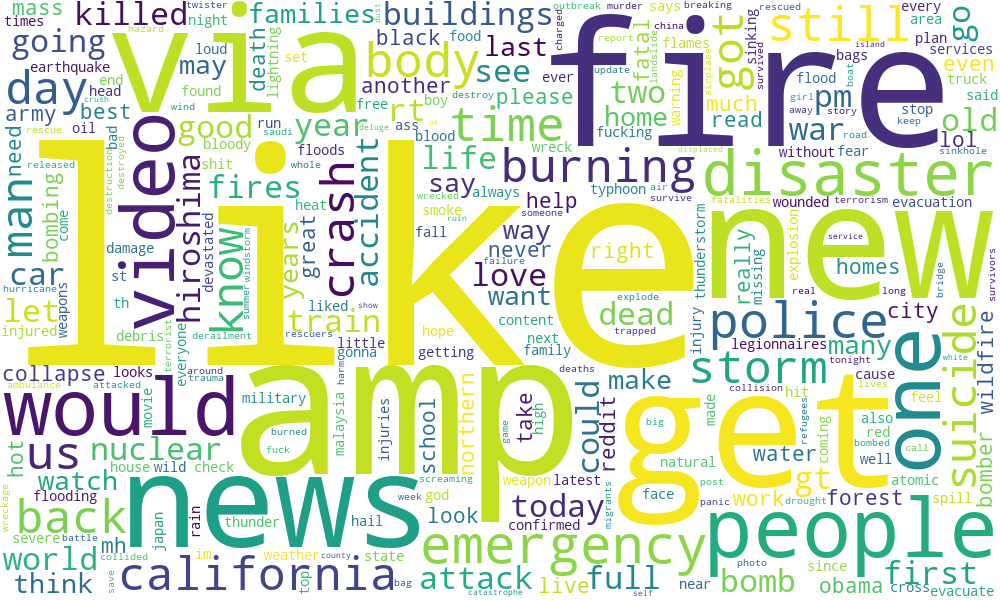

In [10]:
# wordcloud image of above (with more words) 
from PIL import Image
from wordcloud import WordCloud

def generate_wc_from_counts(counts):
    wc = WordCloud(background_color="white", width=1000, height=600, contour_width=3,
               contour_color='steelblue', max_words=300, 
               relative_scaling=0.5,normalize_plurals=False, random_state=0).generate_from_frequencies(counts)
    return wc

wc = generate_wc_from_counts(counts)
wc.to_image()

After vizualizing top words, it seems like we may need to **lemmatize** our words; in essence, lemmatization seeks to remove inflectional endings of words and reduce to a common base word. For instance, if the words 'burn', 'burns', and 'burning' appear in our corpus, lemmatization would reduce these words to their common base word 'burn'. This makes it much easier to conduct text analysis as we no longer have to take into account the various inflections in a word.

In [11]:
# lemmatize words in text
from nltk.stem import WordNetLemmatizer

lemmer = WordNetLemmatizer()
train.text = [' '.join([lemmer.lemmatize(word) for word in text.split(' ')]) for text in train.text]

test.text = [' '.join([lemmer.lemmatize(word) for word in text.split(' ')]) for text in test.text]

## Word Embeddings and Modeling

Instead of BOW, we will be using **word embeddings**. There are certain limitations to BOW, such as large feature space and an inability to capture similarity and semantics, so we will opt for word embeddings, which seeks to map words and phrases to vectors of numerical values. Although we won't be looking at semantics here, it is good habit to adopt some of these principles.



In [12]:
# split data into X and y
X_text = train.text
y_text = train.target
X_test_text = test.text

We use spacy to load some pre-trained word vectors and apply them to our corpus. 

In [13]:
import spacy
nlp = spacy.load("en_core_web_lg")
nlp.vocab["amp"].is_stop = True

docs = [nlp(d).vector for d in X_text]
X_text = np.vstack(docs)

docs_test = [nlp(d).vector for d in X_test_text]
X_test_text = np.vstack(docs_test)

In [14]:
# train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_text, y_text, random_state=0)

For binary classification, we have a multitude of models to choose from. Some of these include Logistic Regression, Support Vector Machines (SVM), Decision Trees, and ensemble methods such as Random Forests. We will be using SVM's due to its simplicity and interpretability, and it achieves quite a decent accuracy on the data as well.

**SVM** is a margin-based classifier that seeks to maximize the margin, or hyperplane, between the two classes. The model learns by support vectors, which are data points that are relatively close to or at the margin, and these support vectors influence the position and orientation of the hyperplane. 

We will grid search the kernel to be used for SVM as well as the regularization parameter "C", which is inversely proportional to regularization. So the bigger C is, the less regularization there is, and the smaller the margin, which will in turn have less support vectors. Conversely, the smaller C, the more regularization there is, and the model seeks to fit a larger margin even if there are misclassified points in your training data.

In [15]:
# gridsearch svm hyperparameters 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import KFold

param_grid = {'kernel': ['rbf','linear'], 'C': [0.001, 0.01, 0.1, 1, 1.5, 2, 3, 10]}

grid = GridSearchCV(SVC(), param_grid, cv=10)
grid.fit(X_train, y_train)
print(grid.best_params_)
grid.score(X_test,y_test)

{'C': 1.5, 'kernel': 'rbf'}


0.8109243697478992

From grid searching, we can see that a regularization parameter C = 1.5 with a rfbf kernel achieves the best results. 

We achieve an accuracy of 81.09% on the test set. 

In [16]:
# get predictions for test data and export
y_test_text = grid.predict(X_test_text)
test['target'] = y_test_text
test_export = test.loc[:, ['id', 'target']]
test_export.to_csv('disaster_test_word2vec.csv', index=False)